In [1]:
import nest
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
nest.ResetKernel()


              -- N E S T --
  Copyright (C) 2004 The NEST Initiative

 Version: 3.7.0
 Built: May 24 2024 10:11:53

 This program is provided AS IS and comes with
 NO WARRANTY. See the file LICENSE for details.

 Problems or suggestions?
   Visit https://www.nest-simulator.org

 Type 'nest.help()' to find out more about NEST.



In [2]:
plt.ion()

## To-Do
- Changing GABA conductances in receptor
> Processes that increase the numerical or functional balance of excitatory vs. inhibitory cells or effects can lead to a hyper-excitable state; individuals with such imbalances are at risk for epilepsy. For instance, cortical GABAergic neurons in rodents are largely produced in the anlage of the basal ganglia and migrate tangentially to the cortex (Anderson et al. 1997; Marin & Rubenstein 2001, 2003). Defects in either the production or migration of cortical GABAergic neurons lead to decreased numbers of cortical GABAergic neurons, that result in a hyper-excitable cortex (Powell et al. 2003). Processes that selectively disrupt synaptic maturation of GABAergic neurons would result in a selective enhancement of excitation, and therefore lead to increased ‘noise’ in the cortex.
- Synaptic Plasticity
    - 'tau_Ca': 10000.0 -> Time constant of calcium release, a change in this could change the concentration of Ca in the synaptic cleft altering the release of neurotransmitter. Modifying the short-term synapses to streghten short term synapses
    - Changes in long-term plasticity to streghten long term connections -> mimicking hyper memory

- Synaptic Pruning
    - Implementing over / under pruning

In [99]:
def create_populations():
    """
    Create populations of excitatory and inhibitory neurons with spatial distribution

    Returns:
        layer_e (list): List of excitatory neurons
        layer_i (list): List of inhibitory neurons
    """
    E_neuron_params = {
        "E_L": -60.0,
        "C_m": 250.0,
        "tau_m": 10.0,
        "t_ref": 2.0,
        "V_th": -55.0,
        "V_reset": -60.0,
        "tau_syn_ex": 5.0,
        "tau_syn_in": 10.0
    }

    I_neuron_params = {
        "E_L": -60.0,
        "C_m": 250.0,
        "tau_m": 10.0,
        "t_ref": 2.0,
        "V_th": -55.0,
        "V_reset": -60.0,
        "tau_syn_ex": 5.0,
        "tau_syn_in": 10.0
    }

    pop_size_E = 100
    pop_size_I = 50

    nest.CopyModel("iaf_psc_alpha", "exc_iaf_psc_alpha")
    nest.SetDefaults("exc_iaf_psc_alpha", E_neuron_params)

    nest.CopyModel("iaf_psc_alpha", "inh_iaf_psc_alpha")
    nest.SetDefaults("inh_iaf_psc_alpha", I_neuron_params)

    pos_e = nest.spatial.free(
        pos=nest.random.uniform(min=-0.5, max=0.5),
        num_dimensions=2
    )
    pos_i = nest.spatial.free(
        pos=nest.random.uniform(min=-0.5, max=0.5),
        num_dimensions=2
    )

    layer_e = nest.Create("exc_iaf_psc_alpha", n=pop_size_E, positions=pos_e)
    layer_i = nest.Create("inh_iaf_psc_alpha", n=pop_size_I, positions=pos_i)
    
    return layer_e, layer_i

def spatial_distribution(layer_e, layer_i): 
    """
    Plot the spatial distribution of excitatory and inhibitory neurons

    Args:
        layer_e (list): List of excitatory neurons
        layer_i (list): List of inhibitory neurons
    Returns:
        fig (matplotlib.figure.Figure): Figure object
        ax1 (matplotlib.axes.Axes): Axes object
        ax2 (matplotlib.axes.Axes): Axes object
    """

    positions_e = np.array(nest.GetPosition(layer_e))
    positions_i = np.array(nest.GetPosition(layer_i))

    fig, ax = plt.subplots(1, 2, figsize=(20, 10), dpi=300)
    ax1, ax2 = ax
    
    ax1.scatter(positions_e[:, 0], positions_e[:, 1], c='blue', label='Excitatory')
    ax1.scatter(positions_i[:, 0], positions_i[:, 1], c='red', label='Inhibitory')
    ax1.set_title("Spatial Distribution of Neurons")
    ax1.legend()
    
    fig.tight_layout()
    
    return fig, ax1, ax2

def connect_pop(layer_e, layer_i):
    """
    Connect the populations with specific spatial synaptic rules

    Args:
        layer_e (list): List of excitatory neurons
        layer_i (list): List of inhibitory neurons
    """
    fig, ax1, ax2 = spatial_distribution(layer_e, layer_i)
    # positions_e = np.array(nest.GetPosition(layer_e))
    # positions_i = np.array(nest.GetPosition(layer_i))
    
    delay_connection = 1.0
    exc_weight = 5.0
    g = 0.5 # ratio inhibitory weight to excitatory weight
    inh_weight = -g * exc_weight

    distribution = nest.spatial_distributions.gaussian(nest.spatial.distance, std=0.3)
    conndict = {
        "rule": "pairwise_bernoulli",
        "p": nest.logic.conditional(distribution > 0.3, distribution, 0),
        "mask": {"circular": {"radius": 0.3}},
    }
    

    exc_syn_dict = {"synapse_model": "stdp_synapse", "weight": exc_weight, "delay": delay_connection}
    inh_syn_dict = {"synapse_model": "stdp_synapse", "weight": inh_weight, "delay": delay_connection}
    
    nest.Connect(layer_e, layer_i, conndict, syn_spec=exc_syn_dict)
    nest.Connect(layer_i, layer_e, conndict, syn_spec=inh_syn_dict)
    nest.Connect(layer_e, layer_e, conndict, syn_spec=exc_syn_dict)
    nest.Connect(layer_i, layer_i, conndict, syn_spec=inh_syn_dict)

    connections = nest.GetConnections()
    filtered_connections = [
        conn for conn in connections
        if conn.get("weight") not in [10.0, 1.0]]
    for conn in filtered_connections:
        source, target, weight = conn.get("source"), conn.get("target"), conn.get("weight")
        print(f"Source: {source}, Target: {target}, Weight: {weight}")
    print(filtered_connections)
    print(len(filtered_connections))
    find_plot_connections(filtered_connections, layer_e, layer_i, fig, ax1, ax2)

def find_plot_connections(connections, layer_e, layer_i, fig, ax1, ax2):
    """
    Visualize the connections between the neurons and plot the connectivity matrix

    Args:
        connections (list): List of connections
        layer_e (list): List of excitatory neurons
        layer_i (list): List of inhibitory neurons
        fig (matplotlib.figure.Figure): Figure object
        ax1 (matplotlib.axes.Axes): Axes object
        ax2 (matplotlib.axes.Axes): Axes object
    """
    # source_node = int(input("Enter the source node: "))
    source_node = 5
    center_neuron = nest.FindCenterElement(layer_e)
    cn_coords = center_neuron.spatial['positions']
    print(f"Center Neuron coords: {cn_coords}")
    
    print(connections)
    # connection_details = nest.GetStatus(connections, keys=["source", "target", "weight"])
    # print(connection_details)
    
    positions_exc = [(i + 1, pos) for i, pos in enumerate(layer_e.spatial["positions"])]
    start_index_inh = len(positions_exc) + 1 
    positions_inh = [(i + start_index_inh, pos) for i, pos in enumerate(layer_i.spatial["positions"])]
    print(positions_exc)
    print(positions_inh)
    
    positions_exc_dict = {neuron_id: pos for neuron_id, pos in positions_exc}
    positions_inh_dict = {neuron_id: pos for neuron_id, pos in positions_inh}
    print(positions_exc_dict)
    print(positions_inh_dict)

    source_pos = positions_exc_dict.get(source_node, None) or positions_inh_dict.get(source_node, None)
    print(source_pos)
    
    if source_pos is None:
        print(f"Source node {source_node} not found in the network.")
    else: 
        ax1.scatter(source_pos[0], source_pos[1], c='purple', label=f'Source Node {source_node}')
    
    for i, conn in enumerate(connections):
        source = conn.get("source")
        if source_node == source:
            target_node = conn.get("target")
            target_pos = positions_exc_dict.get(target_node, None) or positions_inh_dict.get(target_node, None)
            print(source_pos, target_pos)
            ax1.plot(
            [source_pos[0], target_pos[0]],
            [source_pos[1], target_pos[1]],
            c='black', alpha=0.2)
        else:
            continue 

    fig.canvas.draw()
    fig.tight_layout()

    plot_connectivity_matrix(len(layer_e) + len(layer_i), connections, ax2)
    plt.show()

def plot_connectivity_matrix(total_neurons, connection_details, ax):
    """
    Plot the connectivity matrix of the network

    Args:
    """
    weight_matrix = np.zeros((total_neurons, total_neurons))
    for conn in connection_details:
        source = conn.get("source") - 1 
        target = conn.get("target") - 1
        weight = conn.get("weight")
        weight_matrix[source][target] = weight
    
    print(weight_matrix.shape)

    sns.heatmap(weight_matrix, cmap='viridis', ax=ax)


def create_thalamic_input(layer_e):
    """
    Create a Poisson generator to simulate thalamic input to the excitatory neurons
    """
    thalamic_input = nest.Create("poisson_generator", params={"rate": 1000.0})
    nest.Connect(thalamic_input, layer_e, syn_spec={"weight": 10.0, "delay": 1.0}) 

def recording_devices(layer_e, layer_i):
    """
    Connect recording devices
    """
    sr_e = nest.Create("spike_recorder")
    nest.Connect(layer_e, sr_e)
    sr_i = nest.Create("spike_recorder")
    nest.Connect(layer_i, sr_i)
    multimeter_e = nest.Create("multimeter", params={"record_from": ["V_m"], "interval": 0.1})
    multimeter_i = nest.Create("multimeter", params={"record_from": ["V_m"], "interval": 0.1})
    nest.Connect(multimeter_e, layer_e)
    nest.Connect(multimeter_i, layer_i)
    print(nest.GetConnections())
    return multimeter_e, multimeter_i, sr_e, sr_i

def plot_spikes(sr_e, sr_i):
    spike_events_e = nest.GetStatus(sr_e, "events")[0]
    print(spike_events_e)
    spike_events_i = nest.GetStatus(sr_i, "events")[0]
    print(spike_events_i)
    
    senders_e = spike_events_e["senders"]
    times_e = spike_events_e["times"]

    senders_i = spike_events_i["senders"]
    times_i = spike_events_i["times"]

    fig, ax = plt.subplots(1, 1, figsize=(10, 5), dpi=300)
    ax.scatter(times_e, senders_e, s=1, label="Excitatory", color="red")
    ax.scatter(times_i, senders_i, s=1, label="Inhibitory", color="blue")
    ax.set_xlabel("Time (ms)")
    ax.set_ylabel("Neuron ID")
    ax.legend()
    plt.show()

def create_and_simulate():
    pass

 source   target   synapse model   weight   delay 
-------- -------- --------------- -------- -------
      1      152  static_synapse    1.000   1.000
      2      152  static_synapse    1.000   1.000
      3      152  static_synapse    1.000   1.000
      4      152  static_synapse    1.000   1.000
      5      152  static_synapse    1.000   1.000
      6      152  static_synapse    1.000   1.000
      7      152  static_synapse    1.000   1.000
      8      152  static_synapse    1.000   1.000
      9      152  static_synapse    1.000   1.000
     10      152  static_synapse    1.000   1.000
     11      152  static_synapse    1.000   1.000
     12      152  static_synapse    1.000   1.000
     13      152  static_synapse    1.000   1.000
     14      152  static_synapse    1.000   1.000
     15      152  static_synapse    1.000   1.000
     ⋮        ⋮               ⋮        ⋮       ⋮ 
    155      136  static_synapse    1.000   1.000
    155      137  static_synapse    1.000   1.00

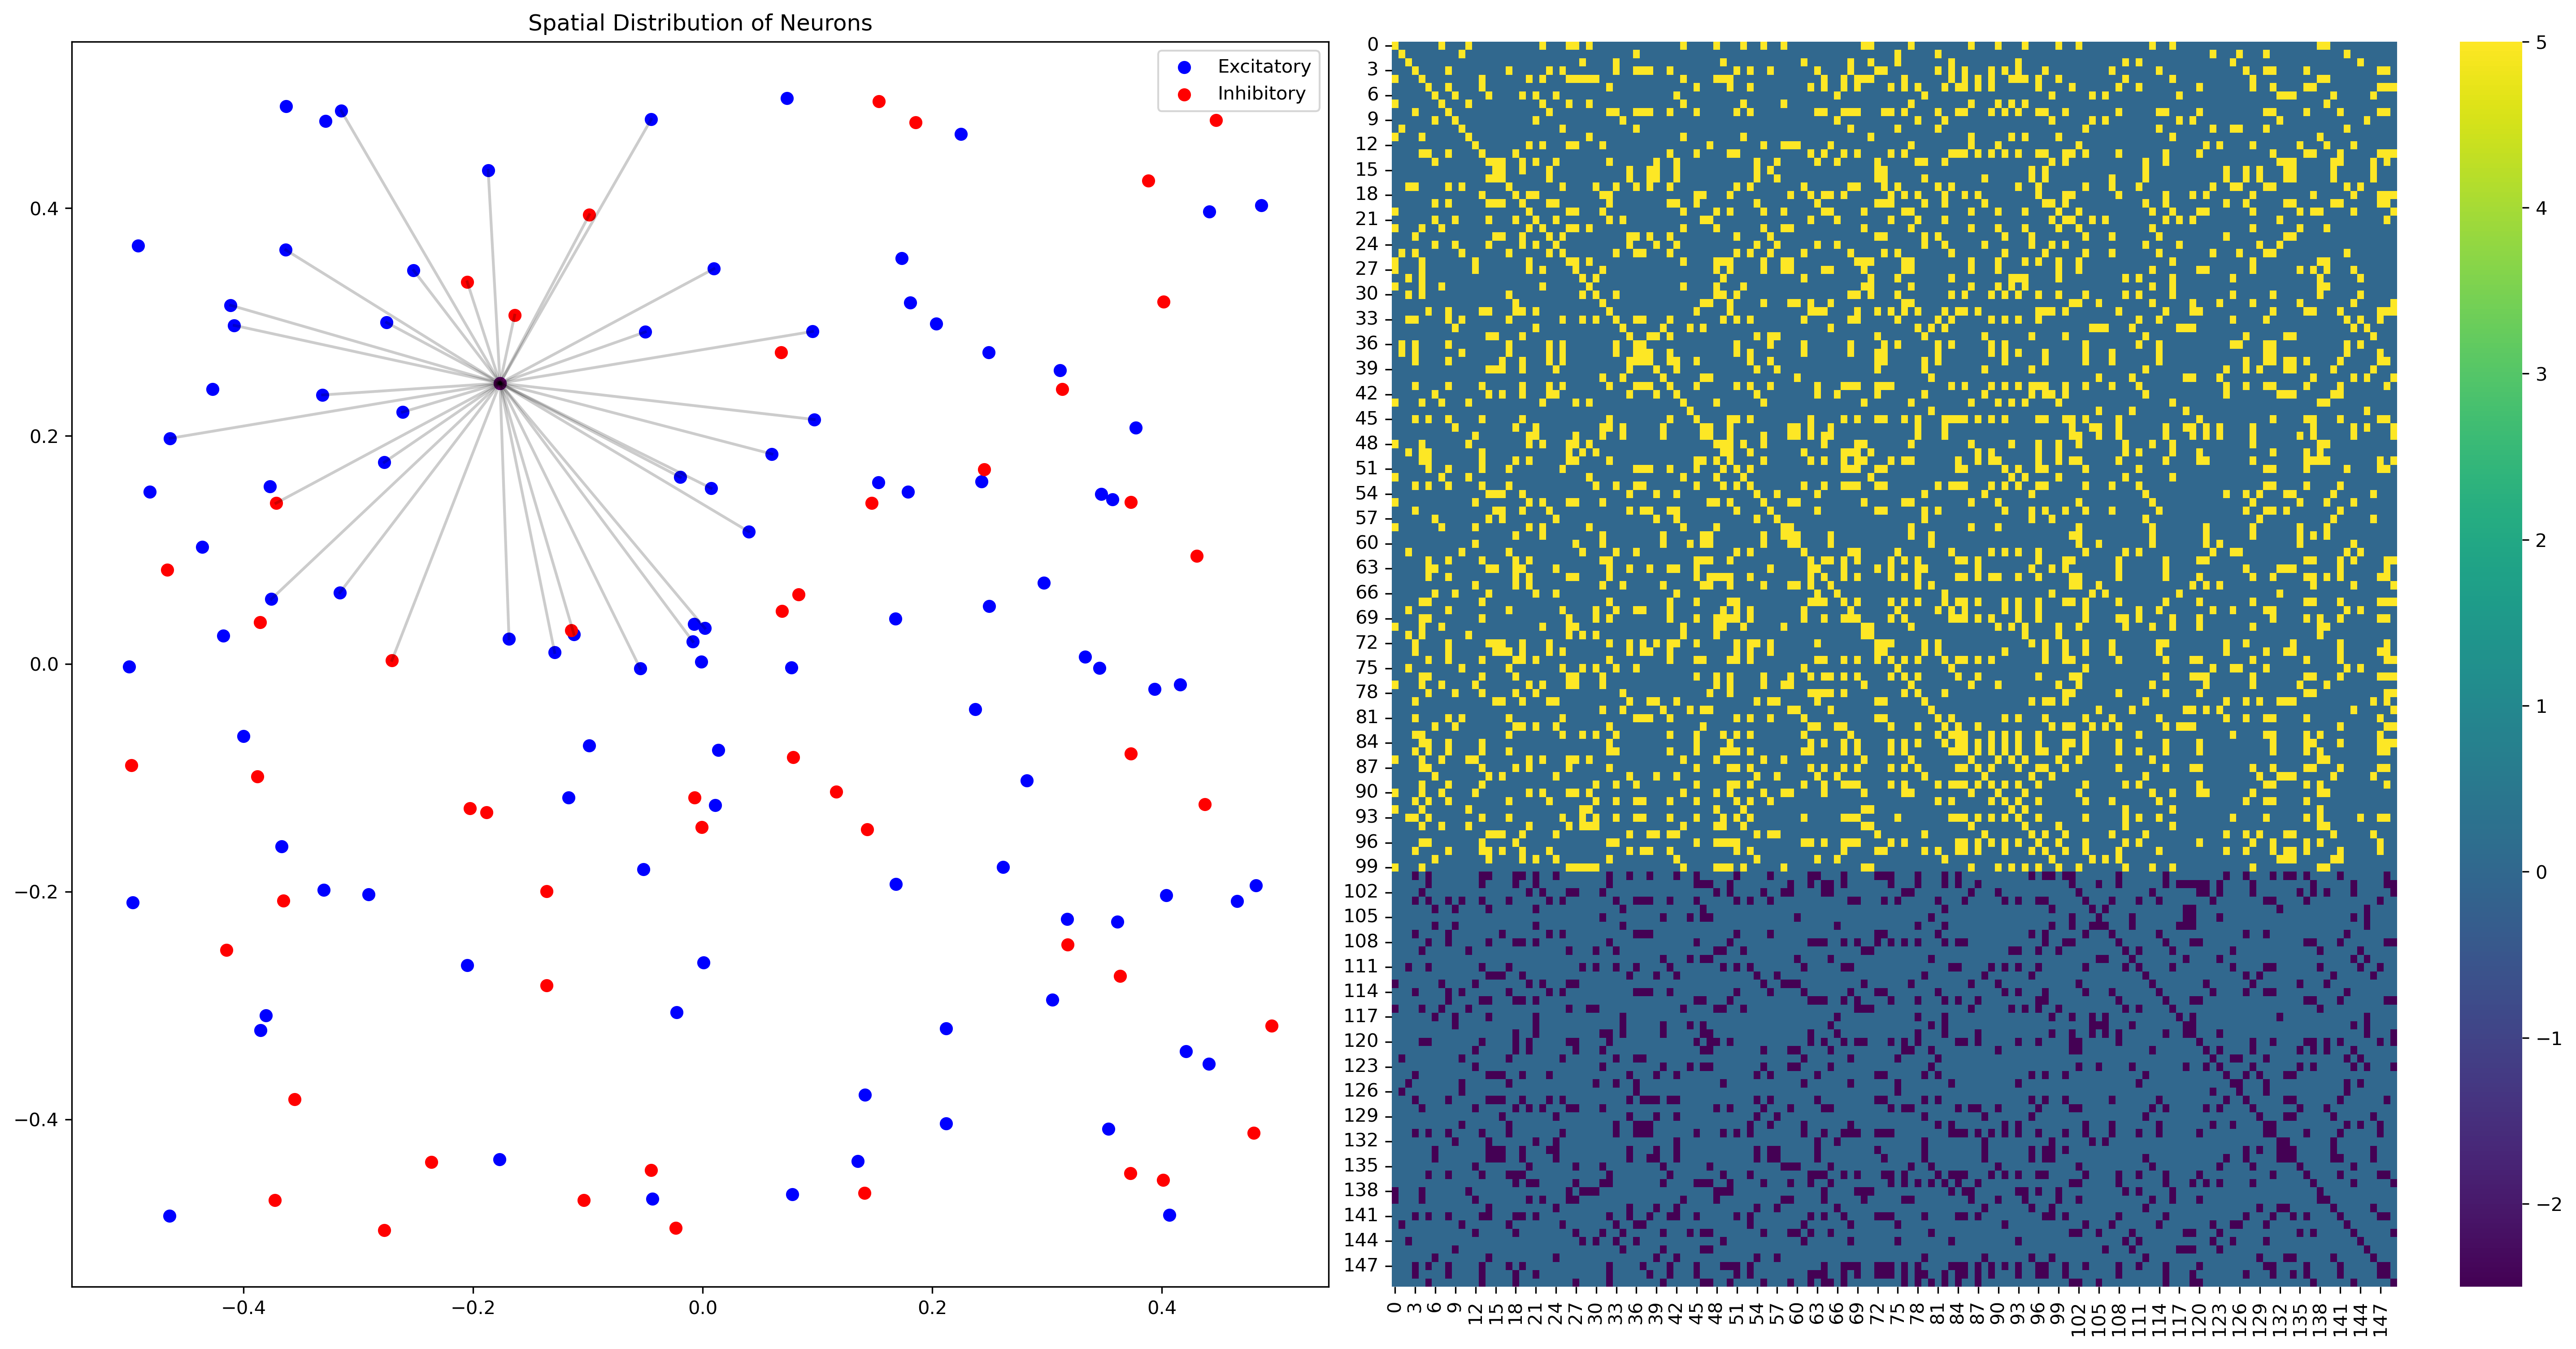

{'senders': array([80, 71, 11, ..., 91, 96, 99]), 'times': array([  24.7,   25.4,   26.2, ...,  999.5, 1000. ,  999.9])}
Jan 04 13:38:20 NodeManager::prepare_nodes [Info]: 
    Preparing 155 nodes for simulation.

Jan 04 13:38:20 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 155
    Simulation time (ms): 1000
    Number of OpenMP threads: 1
    Not using MPI

Jan 04 13:38:20 SimulationManager::run [Info]: 
    Simulation finished.

{'senders': array([104, 132, 137, ..., 143, 146, 147]), 'times': array([ 53.3,  53.6,  53.3, ..., 999.6, 999.5, 999.6])}


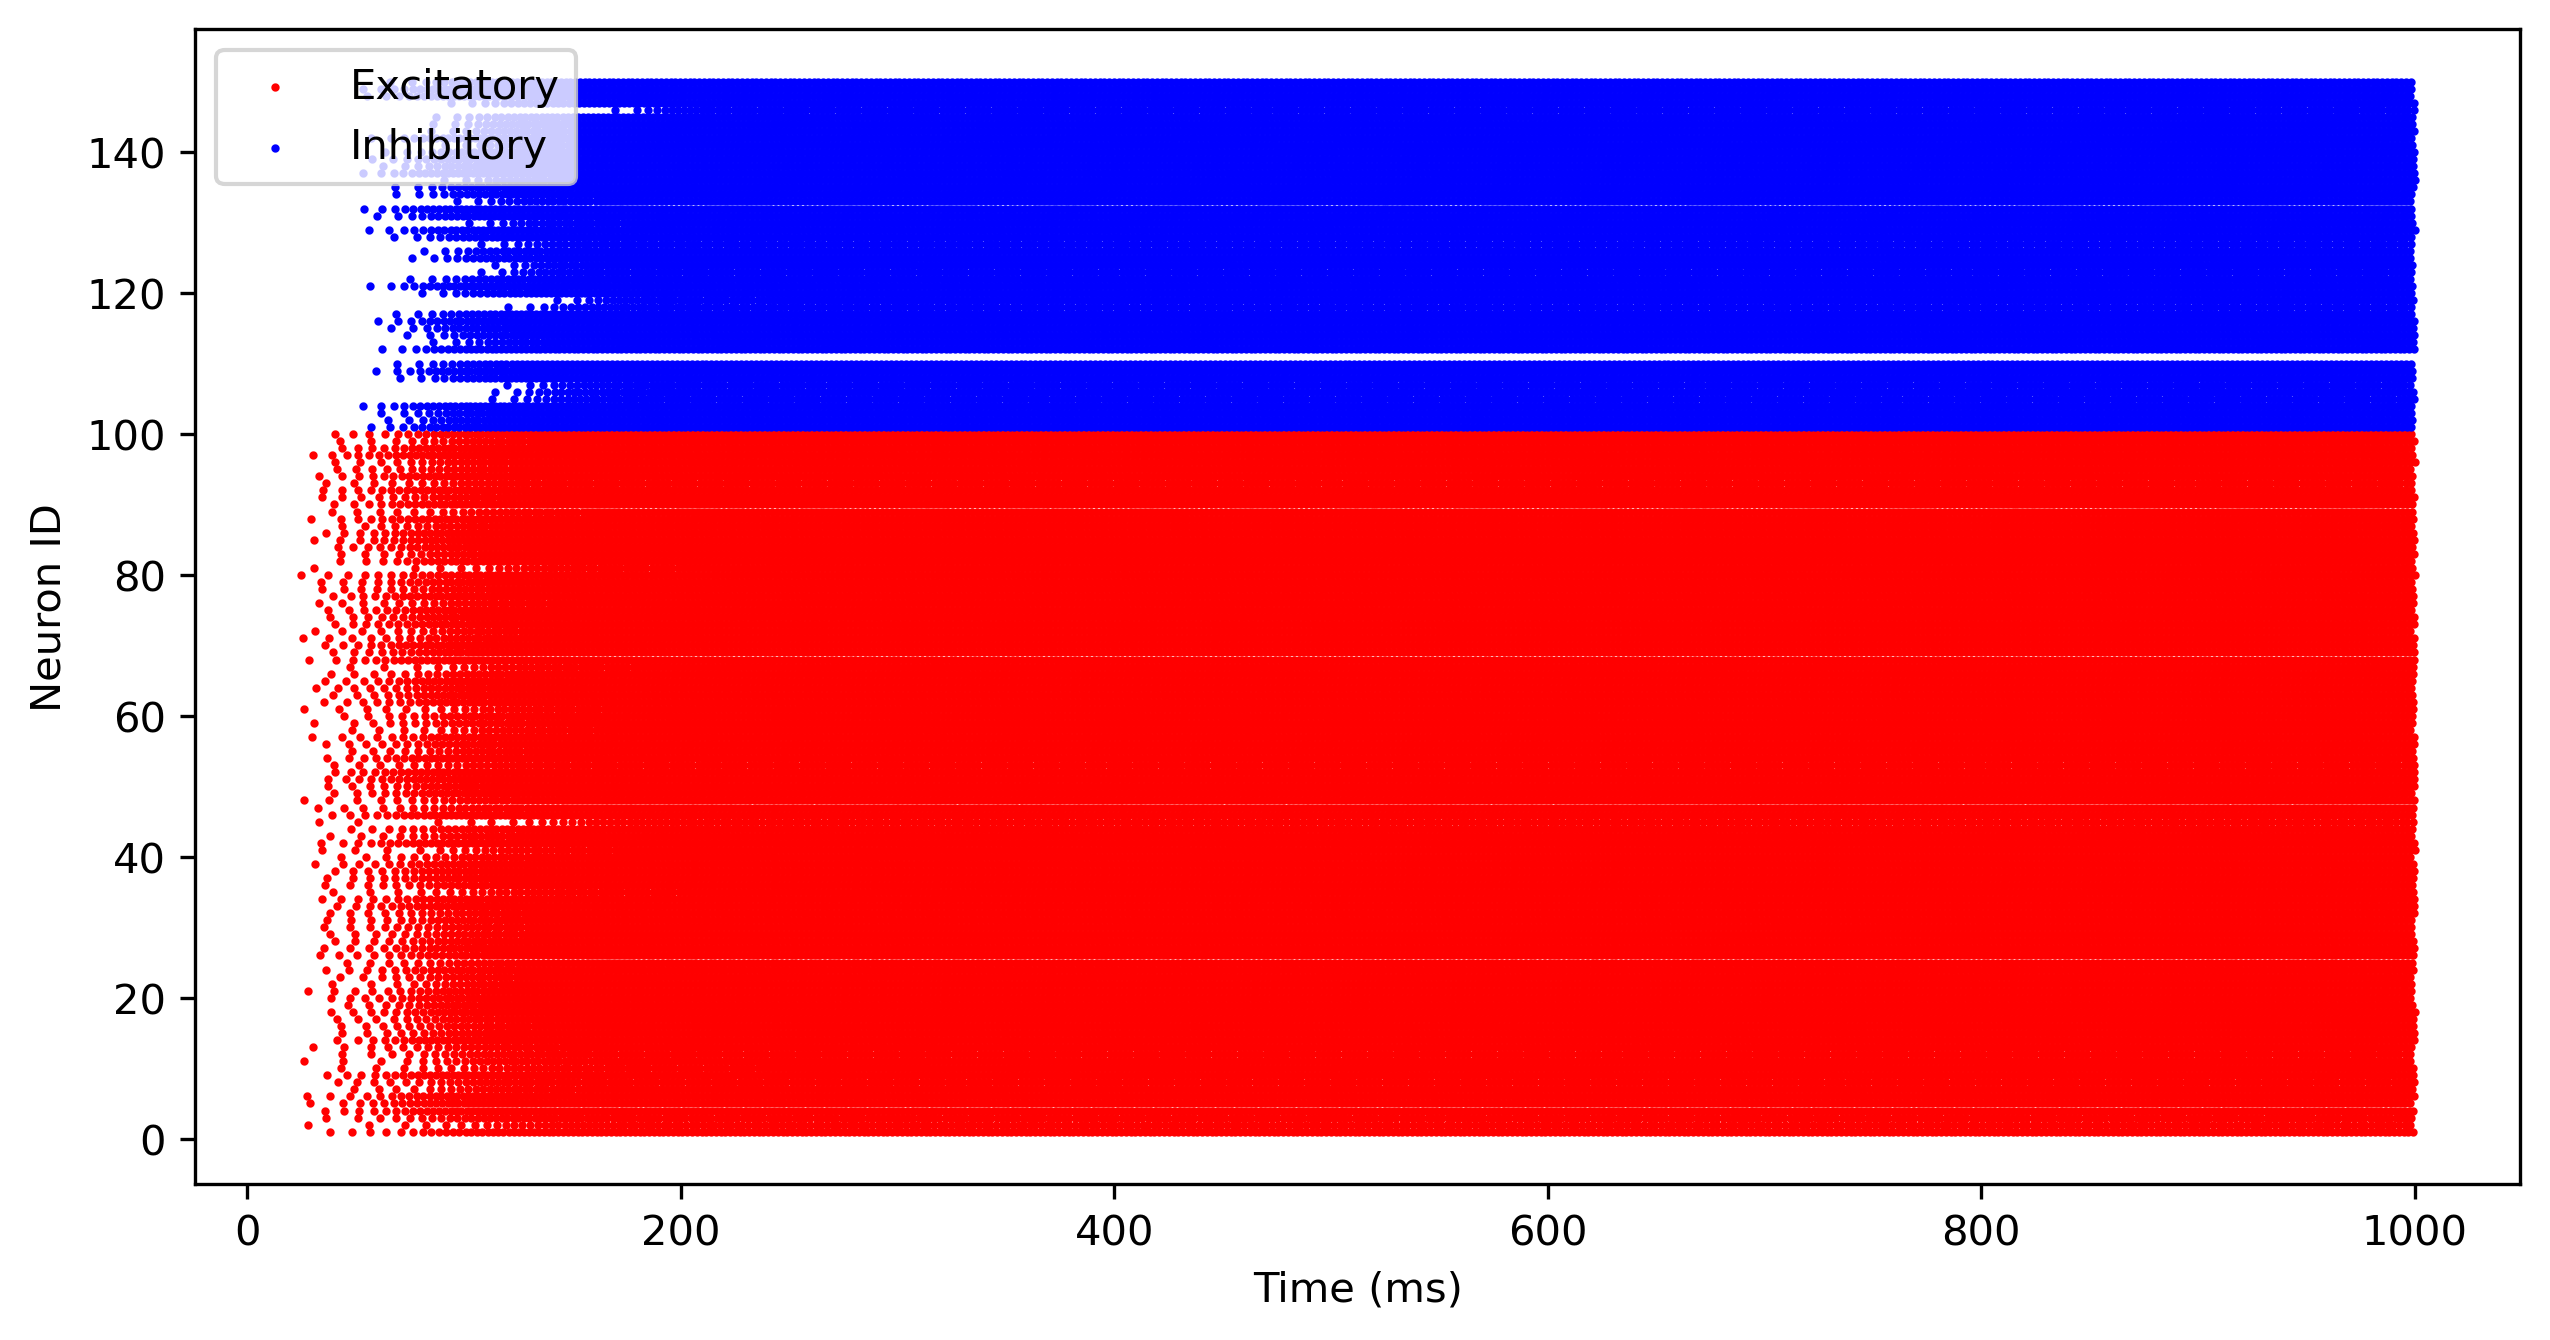

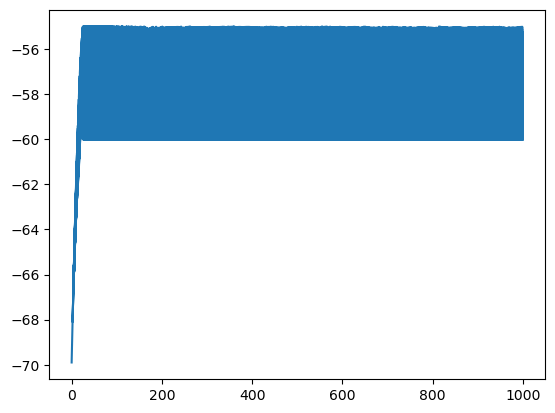

 source   target   synapse model   weight   delay 
-------- -------- --------------- -------- -------
      1      152  static_synapse    1.000   1.000
      2      152  static_synapse    1.000   1.000
      3      152  static_synapse    1.000   1.000
      4      152  static_synapse    1.000   1.000
      5      152  static_synapse    1.000   1.000
      6      152  static_synapse    1.000   1.000
      7      152  static_synapse    1.000   1.000
      8      152  static_synapse    1.000   1.000
      9      152  static_synapse    1.000   1.000
     10      152  static_synapse    1.000   1.000
     11      152  static_synapse    1.000   1.000
     12      152  static_synapse    1.000   1.000
     13      152  static_synapse    1.000   1.000
     14      152  static_synapse    1.000   1.000
     15      152  static_synapse    1.000   1.000
     ⋮        ⋮               ⋮        ⋮       ⋮ 
    150       77    stdp_synapse    45.01   1.000
    150       48    stdp_synapse    49.19   1.00

In [102]:
nest.ResetKernel()
layer_e, layer_i = create_populations()
# spatial_distribution(layer_e, layer_i)
create_thalamic_input(layer_e)
m_e, m_i, sr_e, sr_i = recording_devices(layer_e, layer_i)
connect_pop(layer_e, layer_i)
nest.Simulate(1000.0)
plot_spikes(sr_e, sr_i)
plt.plot(m_e.get("events")["times"], m_e.get("events")["V_m"])
plt.show()
print(nest.GetConnections())

In [7]:
nest.GetDefaults("iaf_psc_alpha_multisynapse")

{'archiver_length': 0,
 'available': (0,),
 'beta_Ca': 0.001,
 'C_m': 250.0,
 'Ca': 0.0,
 'capacity': (0,),
 'E_L': -70.0,
 'element_type': 'neuron',
 'elementsize': 824,
 'frozen': False,
 'global_id': 0,
 'has_connections': False,
 'I_e': 0.0,
 'instantiations': (0,),
 'local': True,
 'model': 'iaf_psc_alpha_multisynapse',
 'model_id': 50,
 'n_synapses': 1,
 'node_uses_wfr': False,
 'post_trace': 0.0,
 'recordables': ('I_syn', 'V_m', 'I_syn_1'),
 'synaptic_elements': {},
 't_ref': 2.0,
 't_spike': -1.0,
 'tau_Ca': 10000.0,
 'tau_m': 10.0,
 'tau_minus': 20.0,
 'tau_minus_triplet': 110.0,
 'tau_syn': (2.0,),
 'thread': -1,
 'thread_local_id': -1,
 'type_id': 'iaf_psc_alpha_multisynapse',
 'V_m': -70.0,
 'V_min': -inf,
 'V_reset': -70.0,
 'V_th': -55.0,
 'vp': -1}

In [8]:
nest.GetDefaults("stdp_synapse")['receptor_type']

0